In [7]:
import glob
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict
from lasagne_utils import load_log

font = {'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
%matplotlib inline

def get_min_mean_max(log_files, key='val_acc', clip_to_shortest=True, clip_length=None):
    logs = []
    for log_file in log_files:
        logs.append(load_log(log_file, append_dir=False))
    if clip_to_shortest:
        clip_length = np.min([len(log[key]) for log in logs])
    min_line = np.min([log[key][:clip_length] for log in logs], axis=0)
    mean_line = np.mean([log[key][:clip_length] for log in logs], axis=0)
    max_line = np.max([log[key][:clip_length] for log in logs], axis=0)
    return min_line, mean_line, max_line

def get_mean_std_at_pos(log_files, key, pos=-1):
    logs = []
    for log_file in log_files:
        logs.append(load_log(log_file, append_dir=False))
    scores = [log[key][pos] for log in logs]
    mean = np.mean(scores)
    std = np.std(scores)
    return mean, std

In [18]:
result_files = glob.glob('./models/freq_task*final.log')
results = defaultdict(lambda:defaultdict(list) )

for result_file in result_files:
    result_attribs = result_file.split('_')
    net_type_key = '--'.join(result_attribs[3:6])
    run_type_key = '--'.join(result_attribs[6:12])
    results[run_type_key][net_type_key].append(result_file)

print(results.keys())
print(results.values()[0].keys())

order_run_type = {'reg--samp--0--samp--res--0.0': 2,
                  'reg--samp--1--samp--res--0.1': 1,
                  'reg--samp--1--samp--res--1.0': 0}
order_net_type = {'plstm--bn--0':0, 'lstm--bn--1':2, 'lstm--bn--0':1}

means  = np.zeros( (len(results.keys()), len(results.values()[0])) )
stds   = np.zeros( (len(results.keys()), len(results.values()[0])) )
counts = np.zeros( (len(results.keys()), len(results.values()[0])) )
for run_key in results.keys():
    for net_key in results[run_key].keys():
        run_mean, run_std = get_mean_std_at_pos(results[run_key][net_key], 'val_acc', 49)
        run_idx, net_idx = order_run_type[run_key], order_net_type[net_key]
        means[run_idx][net_idx] = run_mean
        stds[run_idx][net_idx] = run_std
        counts[run_idx][net_idx] += len(results[run_key][net_key])
        
print('Means: {}'.format(means))
print('Stds: {}'.format(stds))
print('Counts: {}'.format(counts))
print('Done.')

['reg--samp--0--samp--res--0.0', 'reg--samp--1--samp--res--0.1', 'reg--samp--1--samp--res--1.0']
['plstm--bn--0', 'lstm--bn--1', 'lstm--bn--0']
Means: [[ 99.0625     70.546875   99.4140625]
 [ 98.6328125  51.9140625  51.9140625]
 [ 96.2890625  56.8359375  64.921875 ]]
Stds: [[  0.14615849  23.17410591   0.21395412]
 [  0.77142256   0.73495655   0.73495655]
 [  0.           9.67063174  11.78147277]]
Counts: [[ 5.  5.  5.]
 [ 5.  5.  5.]
 [ 1.  5.  5.]]
Done.


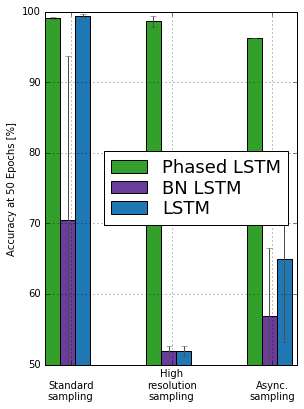

In [16]:
N = 3
# means = np.array([[95, 95, 95], [95, 55, 50], [95,55,50]])
#stds  = np.array([[5, 5, 5], [5, 5, 5], [5,5,5]])

ind = np.arange(N)  # the x locations for the groups
width = 0.15         # the width of the bars

fig, ax = plt.subplots(figsize=(5,7))
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(ind + 0*width, means[:,0], width, color='#33a02c', yerr=stds[:,0], error_kw=error_config)
rects2 = ax.bar(ind + 1*width, means[:,1], width, color='#6a3d9a', yerr=stds[:,1], error_kw=error_config)
rects3 = ax.bar(ind + 2*width, means[:,2], width, color='#1f78b4', yerr=stds[:,2], error_kw=error_config)

# add some text for labels, title and axes ticks
ax.set_ylabel('Accuracy at 50 Epochs [%]')
ax.set_xticks(ind + 1.7*width)
ax.set_xticklabels(('\nStandard\nsampling', 'High\nresolution\nsampling', '\nAsync.\nsampling'))

ax.legend((rects1[0], rects2[0], rects3[0]), ('Phased LSTM', 'BN LSTM', 'LSTM'), loc='center right', labelspacing=0.15, fontsize=18)

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

plt.grid(which='both')
plt.ylim([50, 100])


plt.gcf().subplots_adjust(bottom=0.2, left=0.2)